# Vamos simular um estratégia que vai tomar decisões baseada na probabilidade passada de um retorno positivo em determinado dia do mês:

In [260]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm 
from scipy import stats 
from pandas_datareader import data as dt 

# Construimos funções que vão rodar a estratégia:

In [200]:
def regra_estrategia(df): 
    if df['Pr Dia']>df['Pr Geral']: 
        return df['Retornos']
    else :
        return -df['Retornos']

def estrategia_probabilidades(df,dias_treino): 
    df['Dias'] = df.index.day
    df['Retornos']= df['Adj Close'].pct_change()
    df['Positivo/Negativo']=(df['Retornos']>0).astype(int)
    df['Pr Geral']= (df['Retornos']>0).expanding().mean()
    df['Pr Dia']=np.nan
    for i in range(len(df))[dias_treino:]:
        df['Pr Dia'][i]=(df.iloc[:i-1].groupby('Dias').mean().loc[df['Dias'][i],'Positivo/Negativo'])  
    df['Retornos Estratégia']=df.apply(regra_estrategia,axis=1)
    return df 

# Rodamos a estratégia e plotamos os resultados: 

In [239]:
#Definimos o ativo em que queremos testar e o número de dias de treino: 
ativo = 'T'
dias_de_treino = 4000

C:\Users\pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


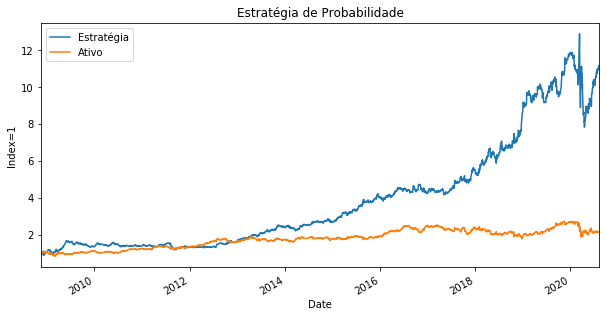

In [240]:
#Pegamos os dados do ativo que queremos testar: 
data = dt.DataReader(ativo,data_source='yahoo',start='1993-01-01')

#Rodamos a estratégia e plotamos os resultados: 
performance = estrategia_probabilidades(data,dias_de_treino).iloc[dias_de_treino:]['Retornos Estratégia'].add(1).cumprod()
performance.plot(figsize=(10,5),label='Estratégia')
(data['Adj Close'].iloc[dias_de_treino:]/data['Adj Close'].iloc[dias_de_treino]).plot(label='Ativo')
plt.title('Estratégia de Probabilidade')
plt.ylabel('Index=1')
plt.legend(loc=0)
plt.show()

# Plotamos os retornos anuais da estratégia: 

In [245]:
df = (performance.resample('Y',kind='period').last().pct_change()*100).to_frame().iloc[1:]
df['Retornos Ativo'] = (data['Adj Close'].iloc[dias_de_treino:]/data['Adj Close'].iloc[dias_de_treino]).resample('Y',kind='period').last().pct_change()*100
df

,Retornos Estratégia,Retornos Ativo
Date,,
2009,28.744635,4.677663
2010,3.410875,11.602586
2011,-5.424736,9.023891
2012,23.773034,17.487685
2013,48.781045,9.722139
2014,10.687856,0.659415
2015,49.985871,8.319801
2016,6.233939,29.874402
2017,28.961383,-4.005831


# Plotamos o underwater: 

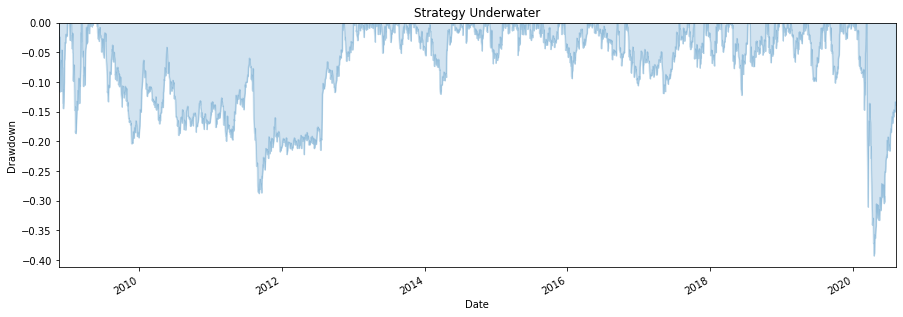

In [266]:
(performance/performance.cummax()-1).plot.area(alpha=0.2,figsize=(15,5))
plt.ylabel('Drawdown')
plt.title('Strategy Underwater')
plt.show()

# Regressão linear entre as probabilidades diárias e os retornos de cada dia: 

C:\Users\pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                            OLS Regression Results                            
Dep. Variable:               Retornos   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     15.44
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           8.70e-05
Time:                        08:48:49   Log-Likelihood:                 8662.3
No. Observations:                2951   AIC:                        -1.732e+04
Df Residuals:                    2949   BIC:                        -1.731e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.002     -3.758      0.0

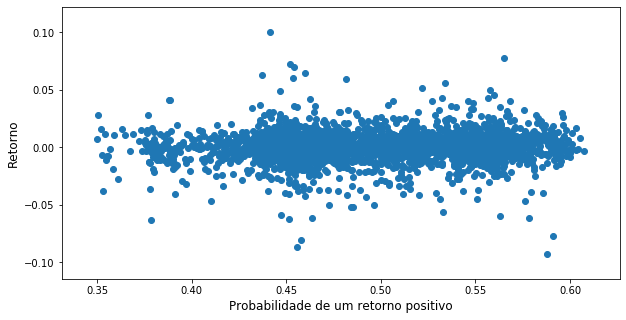

In [272]:
X=estrategia_probabilidades(data,dias_de_treino)['Pr Dia'].iloc[dias_de_treino:]
Y = estrategia_probabilidades(data,dias_de_treino)['Retornos'].iloc[dias_de_treino:]
X1=sm.add_constant(X)
reg = sm.OLS(Y,X1).fit()
resultados = reg.summary()
print(resultados)
plt.figure(figsize=(10,5))
plt.scatter(X,Y)
plt.ylabel('Retorno',fontsize=12)
plt.xlabel('Probabilidade de um retorno positivo',fontsize=12)
plt.show()